<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/analyze_keypoint_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook analyzes a YOLOv8 set of pose labels to understand the distribution of keypoints, links connecting keypoints, and possible ratios between links, in the labels.  This gives us an idea of how realistic it is to use pose data as a way to identify different images of the same cat.  Apart from the accuracy of the pose estimation model, just the presence or absence of keypoints limits the kind of comparisons we can do.

In [41]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

In [2]:
!unzip feral-cat-pose-detection-6.v4i.yolov8.zip

Archive:  feral-cat-pose-detection-6.v4i.yolov8.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
  inflating: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/group0002_jpeg_cat-4_png.rf.5405d08e974c586e35ed6661df314415.jpg  
 extracting: test/images/group0006_jpeg_cat-0_png.rf.a2664719e5fac6b27537d25990fbca75.jpg  
 extracting: test/images/group0006_jpeg_cat-9_png.rf.f68a1aac4e761557adbb921d92a0b81e.jpg  
 extracting: test/images/group0010_jpeg_cat-1_png.rf.39707877a9b1f4d548e0e9c1f4725ae4.jpg  
 extracting: test/images/group0017_jpeg_cat-2_png.rf.96056f3114ec4674f2f8c0a4c6c8b49d.jpg  
 extracting: test/images/group0059_jpeg_cat-1_png.rf.02701404279548e7995db202e7b77cee.jpg  
 extracting: test/images/group0067_cat-5_png.rf.f7f50b8af5d6a2b0223b118b8f0da62d.jpg  
 extracting: test/images/group0069_jpeg_cat-0_png.rf.9c101f4bdcd929846a220b6cb3c92368.jpg  
 extracting: test/images/group0092_jpeg_cat-3_png.rf.b2723

In [12]:
# YOLOv8 label data is stored in one text file corresponding to one image.
# Get all the text files for the training, validation, and testing of the model.
label_files = glob.glob('train/labels/*.txt')
label_files.extend(glob.glob('valid/labels/*.txt'))
label_files.extend(glob.glob('test/labels/*.txt'))
print(len(label_files))

794
1021
1125


In [14]:
# Define the names of keypoints in the same order they are defined in Roboflow.  To determine this,
# export the dataset in COCO format (see this link, click Generate, and choose the COCO format:
# https://app.roboflow.com/feralcatposeestimation/feral-cat-pose-detection-6/4).  Within the JSON file
# _annotations.coco.json, find the "categories" entry, which is an array, and check the second item
# in the array, which is the list of names of keypoints in the order in which they are output to
# a lable file.
keypoints = ["left_earbase",
                "right_earbase",
                "left_eye",
                "right_eye",
                "nose",
                "mouth",
                "withers",
                "tailbase",
                "left_elbow",
                "left_wrist",
                "left_front_paw",
                "right_elbow",
                "right_wrist",
                "right_front_paw",
                "left_knee",
                "left_ankle",
                "left_rear_paw",
                "right_knee",
                "right_ankle",
                "right_rear_paw"]
columns = ['filename']
columns.extend(keypoints)

In [60]:
# A link is defined by two keypoints.  The following named links are the ones that
# seem to make sense.
links = {'earbases': ["left_earbase", "right_earbase"],
         'eyes': ["left_eye", "right_eye"],
         'nose_to_mouth': ["nose", "mouth"],
         'left_ear_to_eye': ["left_earbase", "left_eye"],
         'right_ear_to_eye': ["right_earbase", "right_eye"],
         'left_eye_to_nose': ["nose", "left_eye"],
         'right_eye_to_nose': ["nose", "right_eye"],
         'nose_to_mouth': ["nose", "mouth"],
         'withers_to_tailbase': ["withers", "tailbase"],
         'left_elbow_to_wrist': ["left_elbow", "left_wrist"],
         'right_elbow_to_wrist': ["right_elbow", "right_wrist"],
         'left_knee_to_ankle': ["left_knee", "left_ankle"],
         'right_knee_to_ankle': ["right_knee", "right_ankle"],
         'left_wrist_to_paw': ["left_wrist", "left_front_paw"],
         'right_wrist_to_paw': ["right_wrist", "right_front_paw"],
         'left_ankle_to_paw': ["left_ankle", "left_rear_paw"],
         'right_ankle_to_paw': ["right_ankle", "right_rear_paw"]}
link_keys = list(links.keys())
link_keys.insert(0, 'filename')

In [34]:
def parse_yolo_label_file(file_path):
  """
  Parse a single YOLOv8 label file.

  :param file_path: The path to the YOLOv8 label file.
  :return: None.
  :side-effects: The global variable df_keypoints is filled with the parsed data.
  """
    with open(file_path, 'r') as f:
        lines = f.readlines()
        if len(lines) == 0:
            return
        label_components = lines[0].strip().split(' ')
        next_keypoint_index = 0
        row_data = {'filename': os.path.basename(file_path)}
        # The first six components in the label file are:
        #   0: Index of the object class (0 for the one category -- cat)
        #.  1,2: x-center and y-center of the bounding box
        #.  3,4: width and height of bounding box
        #   5,6,7: x and y coordinates of keypoint 0, and keypoint visibility
        #   8, 9, 10: same for keypoint 1, and so on
        # Visibility: 0 => deleted kp, 1 => occluded kp, 2 => visible kp
        # All our kps should be either deleted or visible, none occluded.
        for i in range(7, len(label_components), 3):
          if int(label_components[i]) == 2: # keypoint is visible
            row_data[keypoints[next_keypoint_index]] = 1
          else:
            row_data[keypoints[next_keypoint_index]] = 0
          next_keypoint_index += 1
        df_keypoints.loc[len(df_keypoints)] = row_data


In [35]:
# Create a dataframe whose columns are the names of the keypoints, with "filename" coming first.
df_keypoints = pd.DataFrame(columns=columns)

In [36]:
# Process all the label files
for file_path in label_files:
    parse_yolo_label_file(file_path)

,filename,left_earbase,right_earbase,left_eye,right_eye,nose,mouth,withers,tailbase,left_elbow,...,left_front_paw,right_elbow,right_wrist,right_front_paw,left_knee,left_ankle,left_rear_paw,right_knee,right_ankle,right_rear_paw
0,group0823_jpeg_cat-2_png.rf.ddedcdf09c4f852a67...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
1,group0876_jpeg_cat-0_png.rf.96cd812c846806491f...,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,group1040_jpeg_cat-1_png.rf.b9f0cf5f3f252c4bdc...,1,1,1,1,1,1,0,1,0,...,1,1,0,1,0,0,1,0,0,1
3,group0817_jpeg_cat-1_png.rf.d464dc4051884d6f54...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
4,group0049_jpeg_cat-1_png.rf.949e2fe2b10785b8ec...,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5,group0231_cat-0_png.rf.6fdb8cd4eaf182d243ed753...,0,0,0,0,0,0,1,1,0,...,1,1,1,1,0,1,1,1,1,1
6,group0004_jpeg_cat-0_png.rf.67b104d863c3d0a94b...,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,group0435_jpeg_cat-1_png.rf.5d6f0904334914cada...,0,0,0,0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
8,group1085_cat-6_png.rf.10e69de9aac7f76b57c45f1...,1,1,1,1,1,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
9,group0588_jpeg_cat-4_png.rf.1e392d69efd3091702...,0,0,0,0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1


In [40]:
num_labels = len(df_keypoints) # Calc number of lines in df_keypoints before adding Total and Percent rows
df_keypoints.loc['Total'] = 0
df_keypoints.loc['Percent'] = 0
# Sum the number of visible keypoints in each column, where each column is a keypoint
for kp in keypoints:
  keypoint_total = df_keypoints[kp].sum()
  df_keypoints.at['Total', kp] = keypoint_total
  df_keypoints.at['Percent', kp] = keypoint_total / num_labels
print(df_keypoints.loc['Total'])
print(df_keypoints.loc['Percent'])

filename               0
left_earbase       582.0
right_earbase      603.0
left_eye           678.0
right_eye          677.0
nose               637.0
mouth              504.0
withers            339.0
tailbase           403.0
left_elbow         150.0
left_wrist         141.0
left_front_paw     427.0
right_elbow        151.0
right_wrist        118.0
right_front_paw    420.0
left_knee           99.0
left_ankle         106.0
left_rear_paw      199.0
right_knee         109.0
right_ankle        113.0
right_rear_paw     224.0
Name: Total, dtype: object
filename                  0
left_earbase       0.522911
right_earbase      0.541779
left_eye           0.609164
right_eye          0.608266
nose               0.572327
mouth               0.45283
withers            0.304582
tailbase           0.362084
left_elbow         0.134771
left_wrist         0.126685
left_front_paw     0.383648
right_elbow        0.135669
right_wrist         0.10602
right_front_paw    0.377358
left_knee          0.088949


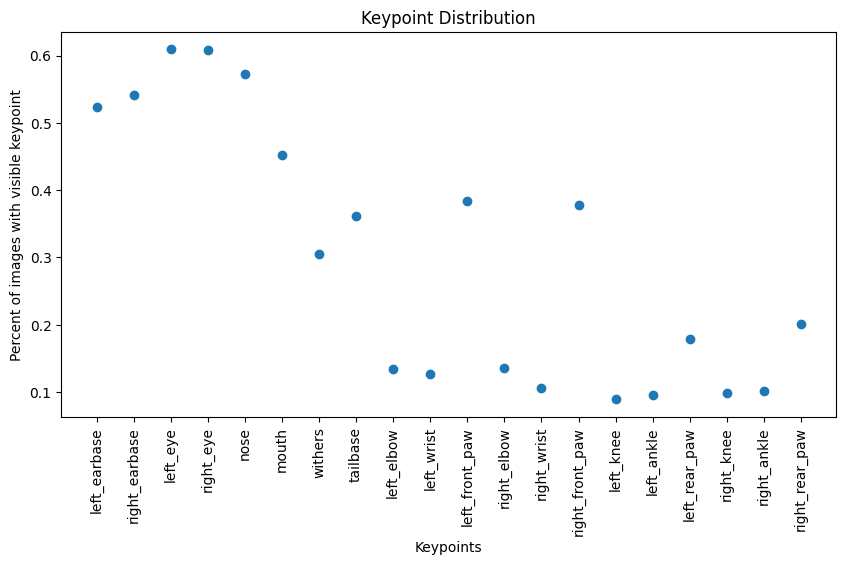

In [47]:
# Create a scatter plot of the keypoint percentages
x = keypoints
y = df_keypoints.drop(columns=['filename']).loc['Percent'].values

plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.xticks(rotation=90)
plt.xlabel('Keypoints')
plt.ylabel('Percent of images with visible keypoint')
plt.title('Keypoint Distribution')
plt.show()

In [65]:
def compute_links(df_keypoints, link_keys):
  """
  Compute the presence or absence of links between keypoints.

  :param df_keypoints: Dataframe with the keypoint visibility information in each column
  :param link_keys: List of names of links to compute
  :return: Dataframe with the presence or absence of the links
  """
  # Create a dataframe whose columns are the names of the links, with "filename" coming first.
  df = pd.DataFrame(columns=link_keys)
  df['filename'] = df_keypoints['filename']
  for link in link_keys[1:]:
    col_for_point_A = links[link][0] # Get name of keypoint which is one end of the link
    col_for_point_B = links[link][1] # Get the name of the other keypoint
    # Add the keypoint visibilities together
    df[link] = df_keypoints[col_for_point_A] + df_keypoints[col_for_point_B]
    # If the value is >= 2, the link is present
    df[link] = df[link].apply(lambda x: 1 if x >= 2 else 0)
  return df

df_links = compute_links(df_keypoints, link_keys)
df_links.head(10)


,filename,earbases,eyes,nose_to_mouth,left_ear_to_eye,right_ear_to_eye,left_eye_to_nose,right_eye_to_nose,withers_to_tailbase,left_elbow_to_wrist,right_elbow_to_wrist,left_knee_to_ankle,right_knee_to_ankle,left_wrist_to_paw,right_wrist_to_paw,left_ankle_to_paw,right_ankle_to_paw
0,group0823_jpeg_cat-2_png.rf.ddedcdf09c4f852a67...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,group0876_jpeg_cat-0_png.rf.96cd812c846806491f...,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0
2,group1040_jpeg_cat-1_png.rf.b9f0cf5f3f252c4bdc...,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0
3,group0817_jpeg_cat-1_png.rf.d464dc4051884d6f54...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,group0049_jpeg_cat-1_png.rf.949e2fe2b10785b8ec...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,group0231_cat-0_png.rf.6fdb8cd4eaf182d243ed753...,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1
6,group0004_jpeg_cat-0_png.rf.67b104d863c3d0a94b...,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
7,group0435_jpeg_cat-1_png.rf.5d6f0904334914cada...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,group1085_cat-6_png.rf.10e69de9aac7f76b57c45f1...,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0
9,group0588_jpeg_cat-4_png.rf.1e392d69efd3091702...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [71]:
# Compute the percentage of each link's presence in the dataset
num_labels = len(df_links)-2 # Calc number of lines in df_links before adding Total and Percent rows
df_keypoints.loc['Total'] = 0
df_keypoints.loc['Percent'] = 0
for link in links:
  link_total = df_links[link].sum()
  df_links.at['Total', link] = link_total
  df_links.at['Percent', link] = link_total / num_labels
print(df_links.loc['Total'])
print(df_links.loc['Percent'])

filename                    0
earbases                565.0
eyes                    678.0
nose_to_mouth           504.0
left_ear_to_eye         583.0
right_ear_to_eye        602.0
left_eye_to_nose        638.0
right_eye_to_nose       637.0
withers_to_tailbase     210.0
left_elbow_to_wrist      82.0
right_elbow_to_wrist     73.0
left_knee_to_ankle       70.0
right_knee_to_ankle      79.0
left_wrist_to_paw       138.0
right_wrist_to_paw      115.0
left_ankle_to_paw        90.0
right_ankle_to_paw       96.0
Name: Total, dtype: object
filename                       0
earbases                0.508551
eyes                    0.610261
nose_to_mouth           0.453645
left_ear_to_eye         0.524752
right_ear_to_eye        0.541854
left_eye_to_nose        0.574257
right_eye_to_nose       0.573357
withers_to_tailbase     0.189019
left_elbow_to_wrist     0.073807
right_elbow_to_wrist    0.065707
left_knee_to_ankle      0.063006
right_knee_to_ankle     0.071107
left_wrist_to_paw       0.124212
r

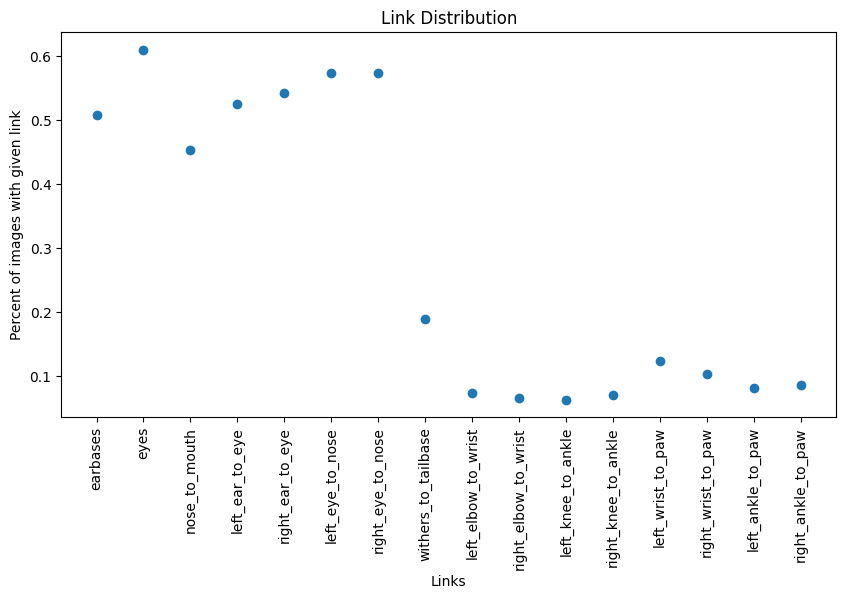

In [74]:
# Create a scatter plot of the link percentages
x = link_keys[1:]
y = df_links.drop(columns=['filename']).loc['Percent'].values

plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.xticks(rotation=90)
plt.xlabel('Links')
plt.ylabel('Percent of images with given link')
plt.title('Link Distribution')
plt.show()